In [1]:
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import random
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_openml
from scipy.stats import multivariate_normal as mvn
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal

# Problem 2
### Loading Data

In [53]:
def load_mnist():
    # load MNIST dataset
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X = np.concatenate((X_train, X_test))
    y = np.concatenate((y_train, y_test))

    # flatten the images from 28x28 to 784
    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])

    # normalize the data
    X = normalize(X)
        
    return X, y

In [3]:
def load_fashion_mnist():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    X = np.concatenate((X_train, X_test))
    y = np.concatenate((y_train, y_test))
    
    # flatten the images from 28x28 to 784
    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])

    # normalize the data
    X = normalize(X)
    return X, y

In [58]:
def load_20ng(n_samples=1000):
    newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(newsgroups.data)
    X = normalize(X)
    X = X[:n_samples,:]
    y = newsgroups.target[:n_samples]
    
    return np.array(X.toarray()), y

In [5]:
def load_spambase(file_path):
    # load the spambase data from the file
    data = np.loadtxt(file_path, delimiter=",")
    
    # separate the features and labels
    X = data[:, :-1]
    y = data[:, -1]
    
    # normalize the features
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    return X, y

### Function Declarations

In [6]:
# function to initialize random centroids
def initialize_centroids(X, k):
    # number of samples
    n_samples = X.shape[0]

    # number of features
    n_features = X.shape[1]
    
    # initialize centroids using k-means++
    centroids = np.zeros((k, n_features))
    centroids[0] = X[np.random.choice(n_samples, size=1), :].flatten()
    for i in range(1, k):
        distances = np.array([min([np.linalg.norm(x - c)**2 for c in centroids[:i]]) for x in X])
        X = np.array(data, dtype=np.float32)
        prob = distances / np.sum(distances)
        cumprob = np.cumsum(prob)
        r = np.random.rand()
        for j, p in enumerate(cumprob):
            if r < p:
                break
        centroids[i] = X[j, :].flatten()

    return centroids

In [7]:
def cluster_assignment(X, centroids):
    # number of samples
    n_samples = X.shape[0]

    # assign each data point to the closest centroid
    clusters = np.zeros(n_samples)
    for i in range(n_samples):
        distances = np.array([np.linalg.norm(X[i] - c)**2 for c in centroids])
        clusters[i] = np.argmin(distances)

    return clusters

In [8]:
def update_centroids(X, clusters, k):
    # number of features
    n_features = X.shape[1]

    # update the centroids
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean(X[clusters == i], axis=0)

    return centroids

In [9]:
def compute_sse(X, clusters, centroids):
    sse = 0
    for i in range(centroids.shape[0]):
        sse += np.sum(np.linalg.norm(X[clusters == i] - centroids[i], axis=1)**2)
    return sse

In [56]:
def kmeans(X, k, max_iters=100, epsilon=1e-5):
    N, D = X.shape
    # Initialize centroids randomly
    centroids = X[np.random.choice(N, k, replace=False)]
    centroids = centroids.astype(np.float16)
    for i in range(max_iters):
        # Assign clusters to each data point
        distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2), dtype = np.float16)
        clusters = np.argmin(distances, axis=1)
        # Calculate the new centroids
        new_centroids = np.zeros((k, D))
        for j in range(k):
            cluster = X[clusters == j]
            new_centroids[j] = cluster.mean(axis=0)
        # Check if the change in centroids is within the tolerance
        delta = np.abs(centroids - new_centroids).sum()
        if delta < epsilon:
            break
        centroids = new_centroids
        
    sse = compute_sse(X, clusters, centroids)
    
    return centroids, clusters, sse

In [51]:
X.shape

(2000, 134410)

In [11]:
#Check KMeans Accuracy
def check_accuracy(y, clusters):
    cluster_labels = [np.argmax([np.sum(clusters == c) for c in range(k)]) for i in range(k)]
    y_pred = [cluster_labels[np.argmax(clusters[i])] for i in range(len(y))]
    accuracy = np.mean(y_pred == y)
    return accuracy

In [12]:
# Display and Compare MNIST Predictions
def display_predictions(clusters, X, y, is_fashion_mnist = False):
    X = X * X.std(axis=0) + X.mean(axis=0)
    if is_fashion_mnist:
        labels = [
        'T-shirt/top',
        'Trouser',
        'Pullover',
        'Dress',
        'Coat',
        'Sandal',
        'Shirt',
        'Sneaker',
        'Bag',
        'Ankle boot'
    ]
    else:
        labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    num_clusters = len(np.unique(clusters))
    fig, axs = plt.subplots(1, num_clusters, figsize=(20,20))
    
    for i in range(num_clusters):
        cluster_indices = np.where(clusters == i)
        cluster_images = X[cluster_indices]
        cluster_labels = y[cluster_indices]
        
        for j in range(5):
            random_index = np.random.randint(0, len(cluster_images))
            image = cluster_images[random_index].reshape(28, 28)
            axs[i].imshow(image, cmap='gray')
            prediction = labels[i]
            actual = labels[int(cluster_labels[random_index])]
            if prediction == actual:
                color = 'green'
            else:
                color = 'red'
            axs[i].set_title('Prediction: {}\nActual: {}'.format(prediction, actual), color=color)
    plt.show()

In [13]:
# Display and Compare 20ng Predictions
def display_20ng_predictions(predictions, X, y):
    """
    Display a random selection of the predicted images and their actual labels.
    :param predictions: The predicted clusters.
    :param X: The input data.
    :param y: The actual labels.
    """
    random_indices = random.sample(range(len(y)), 10)
    for i in random_indices:
        prediction = predictions[i]
        actual = y[i]
        print("Prediction: {}".format(prediction))
        print("Actual: {}".format(actual))
        print("------------------------------")

In [14]:
#Load text files
def load_txt(filename):
    with open(filename, 'r') as file:
        data = file.readlines()
    
    X = []
    for line in data:
        x = [float(val) for val in line.split()]
        X.append(x)
    
    return np.array(X)

In [15]:
def GaussianMixtureModel(X, K, max_iter=100, tol=1e-6):
    N, d = X.shape
    
    # initialize the parameters
    mu = X[np.random.choice(N, K, replace=False)]
    sigma = [np.eye(d) for _ in range(K)]
    W = np.ones((N, K)) / K
    W_prev = np.zeros((N, K))
    
    for i in range(max_iter):
        # calculate the probability density of each point given each Gaussian
        p = np.zeros((N, K))
        for k in range(K):
            p[:, k] = mvn.pdf(X, mean=mu[k], cov=sigma[k])
            p[:, k] = np.where(np.isinf(p[:, k]), 1e-10, p[:, k])
            p[:, k] = np.where(np.isnan(p[:, k]), 1e-10, p[:, k])
        
        W = W * p
        W = W / np.sum(W, axis=1, keepdims=True)
        
        # M step
        for k in range(K):
            mu[k] = np.sum(W[:, k][:, np.newaxis] * X, axis=0) / np.sum(W[:, k])
            sigma[k] = np.cov(X.T, aweights=W[:, k], bias=True)
            
        # check for convergence
        if np.abs(W - W_prev).max() < tol:
            print(f"Converged in {i} steps.")
            break
        W_prev = np.copy(W)
        
    return mu, sigma, W

### Kmeans on MNIST

In [16]:
# run K-Means on MNIST dataset
X, y = load_mnist()
k =10
start = time.time()
centroids, clusters, sse = kmeans(X, k)
end=time.time()
print(end-start)

192.14952111244202


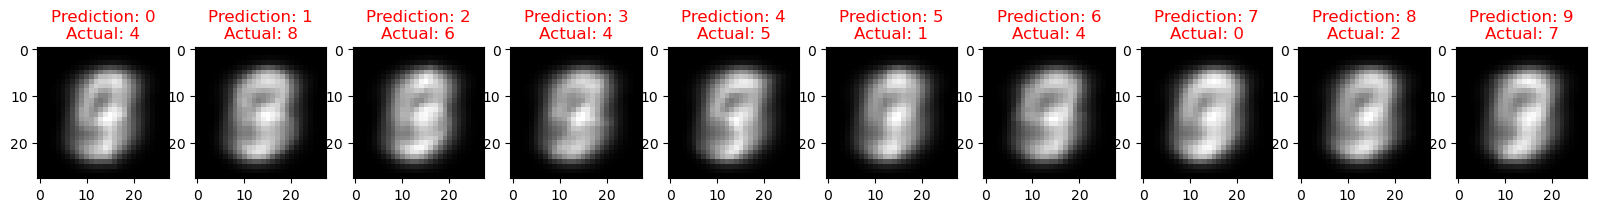

In [17]:
display_predictions(clusters, X, y, is_fashion_mnist=False)

In [18]:
sse

30759.452298524546

In [19]:
accuracy = check_accuracy(y, clusters)
accuracy

0.11252857142857142

### Kmeans on Fashion

In [20]:
X, y =  load_fashion_mnist()
# run K-Means on Fashion MNIST dataset
k =10
start = time.time()
centroids, clusters, sse = kmeans(X, k)
end=time.time()
print(end-start)

91.826247215271


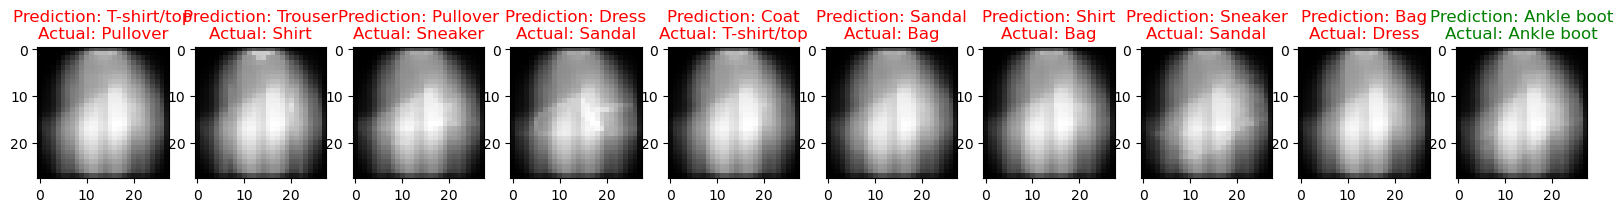

In [21]:
display_predictions(clusters, X, y, is_fashion_mnist=True)

In [22]:
sse

14895.371710159146

In [23]:
accuracy = check_accuracy(y, clusters)
accuracy

0.1

### Kmeans on 20ng

In [59]:
# run K-Means on 20ng dataset
X, y = load_20ng()
k = 20
start = time.time()
centroids, clusters, sse = kmeans(X, k, 10)
end=time.time()
print(end-start)

483.07033252716064


In [60]:
display_20ng_predictions(clusters, X, y)

Prediction: 7
Actual: 19
------------------------------
Prediction: 0
Actual: 10
------------------------------
Prediction: 7
Actual: 7
------------------------------
Prediction: 0
Actual: 7
------------------------------
Prediction: 0
Actual: 8
------------------------------
Prediction: 0
Actual: 13
------------------------------
Prediction: 7
Actual: 1
------------------------------
Prediction: 13
Actual: 12
------------------------------
Prediction: 7
Actual: 7
------------------------------
Prediction: 14
Actual: 1
------------------------------


In [61]:
sse

890.2711641912612

In [62]:
accuracy = check_accuracy(y, clusters)
accuracy

0.042

# Problem 3
### Gaussian Mixtures

In [63]:
#Load and run 2gaussian.txt
X = load_txt("C:/Users/chase/OneDrive/Northeastern Code/DS 5230/Hw 2/2gaussian.txt")
mu, sigma, W = GaussianMixtureModel(X, 2, 10000)

Converged in 1509 steps.


In [64]:
mu

array([[3.01921073, 3.04391247],
       [7.04717707, 3.9983068 ]])

In [65]:
sigma

[array([[1.00202608, 0.01739152],
        [0.01739152, 2.90698691]]),
 array([[0.89287536, 0.45886027],
        [0.45886027, 0.97615191]])]

In [66]:
#Load and run 3gaussian.txt
X = load_txt("C:/Users/chase/OneDrive/Northeastern Code/DS 5230/Hw 2/3gaussian.txt")
mu, sigma, W = GaussianMixtureModel(X, 3, 10000)

Converged in 4017 steps.


In [67]:
mu

array([[3.03157663, 3.33991107],
       [7.03005599, 4.04725089],
       [5.09836611, 7.09714302]])

In [68]:
sigma

[array([[ 0.87260486, -0.03681952],
        [-0.03681952,  3.82302213]]),
 array([[0.93195582, 0.47070961],
        [0.47070961, 1.00703857]]),
 array([[0.77559423, 0.10884574],
        [0.10884574, 0.83305942]])]

# Problem 4
Gaussian Mixture on real data

In [69]:
gm = GaussianMixture(n_components = 2, covariance_type = 'diag')

In [70]:
X, y = load_fashion_mnist()
X, X_test, y, y_test = train_test_split(X, y, test_size = 1/7, random_state = 1)

In [71]:
gms = {}
x=10
scores = np.empty((len(y_test), x))

for i in range(x):
    temp = X[y==i]
    gms[f"gm{i}"] = gm.fit(temp)
    scores[:,i] = gms[f"gm{i}"].score_samples(X_test) * len(temp)/X.shape[0]
    predictions = np.argmax(scores, axis=1)


In [72]:
correct = sum(predictions == y_test)

In [73]:
accuracy = correct / len(y_test)
accuracy

0.6689

In [74]:
X, y = load_spambase("C:/Users/chase/OneDrive/Northeastern Code/DS 5230/Hw 2/spambase/spambase.data")
X, X_test, y, y_test = train_test_split(X, y, test_size = 1/7, random_state = 1)

In [75]:
gms = {}
x=2
scores = np.empty((len(y_test), x))

for i in range(x):
    temp = X[y==i]
    gms[f"gm{i}"] = gm.fit(temp)
    scores[:,i] = gms[f"gm{i}"].score_samples(X_test) * len(temp)/X.shape[0]
    predictions = np.argmax(scores, axis=1)


In [76]:
correct = sum(predictions == y_test)
correct

505

In [77]:
accuracy = correct / len(y_test)
accuracy

0.7674772036474165